In [2]:
using ZipFile, Distributed, CSV, DataFrames, Random, StatsBase, Plots, Statistics, StableRNGs, MLJBase
using Flux
using Flux: logitbinarycrossentropy
using BSON: @save
using Distributions

file = CSV.read("train.csv", DataFrame)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep
,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Float64
1,842,0,2.2,0,1,0,7,0.6
2,1021,1,0.5,1,0,1,53,0.7
3,563,1,0.5,1,2,1,41,0.9
4,615,1,2.5,0,0,0,10,0.8
5,1821,1,1.2,0,13,1,44,0.6
6,1859,0,0.5,1,3,0,22,0.7
7,1821,0,1.7,0,4,1,10,0.8
8,1954,0,0.5,1,0,0,24,0.8
9,1445,1,0.5,0,0,0,53,0.7


In [3]:
# Transfer DataFrame to matrix form
df = file |> Tables.matrix

# Transfer the dataset to 2-classifiers. df_0 represents the result is 0, df_1 represents the result is 1.
# Due to my datasset is binary problems, and each result is 50 percents of the whole dataset. So i didn't add any other pre-actions for dataset. 

mat_0 = df[df[:,21] .<= 1, :]
mat_1 = df[df[:,21] .>= 2, :]


1000×21 Matrix{Float64}:
 1021.0  1.0  0.5  1.0   0.0  1.0  53.0  …   3.0   7.0  1.0  1.0  0.0  2.0
  563.0  1.0  0.5  1.0   2.0  1.0  41.0      2.0   9.0  1.0  1.0  0.0  2.0
  615.0  1.0  2.5  0.0   0.0  0.0  10.0      8.0  11.0  1.0  0.0  0.0  2.0
 1821.0  0.0  1.7  0.0   4.0  1.0  10.0      8.0  18.0  1.0  0.0  1.0  3.0
  769.0  1.0  2.9  1.0   0.0  0.0   9.0      2.0   7.0  0.0  0.0  0.0  3.0
 1520.0  1.0  2.2  0.0   5.0  1.0  33.0  …   9.0  13.0  1.0  1.0  1.0  3.0
  803.0  1.0  2.1  0.0   7.0  0.0  17.0      1.0   4.0  1.0  0.0  1.0  2.0
  838.0  0.0  0.5  0.0   1.0  1.0  13.0      9.0  19.0  1.0  0.0  1.0  3.0
  595.0  0.0  0.9  1.0   7.0  1.0  23.0      2.0  18.0  1.0  1.0  0.0  3.0
  772.0  0.0  1.1  1.0  12.0  0.0  39.0     15.0   3.0  1.0  1.0  0.0  3.0
 1709.0  1.0  2.1  0.0   1.0  0.0  13.0  …   1.0  15.0  1.0  0.0  0.0  3.0
  961.0  1.0  1.4  1.0   0.0  1.0  57.0      9.0   7.0  1.0  1.0  1.0  2.0
  519.0  1.0  1.6  1.0   7.0  1.0  51.0      1.0   4.0  1.0  0.0  1.0  3.0


In [4]:
# randomly select 70% data from data set as the train data

train_data = randsubseq(1:1000, 0.7)
train_df = vcat(mat_0[train_data, :], mat_1[train_data, :])

# select the rest as the test data 

test_data = [i for i in 1:1000 if isempty(searchsorted(train_data, i))]
test_df = vcat(mat_0[test_data, :], mat_1[test_data, :])

584×21 Matrix{Float64}:
 1859.0  0.0  0.5  1.0   3.0  0.0  22.0  …   1.0  10.0  1.0  0.0  0.0  1.0
 1445.0  1.0  0.5  0.0   0.0  0.0  53.0      1.0  20.0  1.0  0.0  0.0  0.0
 1866.0  0.0  0.5  0.0  13.0  1.0  52.0      9.0   3.0  1.0  0.0  1.0  0.0
 1131.0  1.0  0.5  1.0  11.0  0.0  49.0     13.0  16.0  1.0  1.0  0.0  1.0
  682.0  1.0  0.5  0.0   4.0  0.0  19.0      1.0  18.0  0.0  1.0  1.0  1.0
 1514.0  0.0  2.9  0.0   0.0  0.0  27.0  …   3.0  20.0  0.0  1.0  1.0  1.0
 1054.0  1.0  1.8  1.0   3.0  1.0  40.0     12.0  12.0  1.0  0.0  1.0  1.0
 1484.0  0.0  3.0  0.0   3.0  0.0  12.0      4.0  20.0  1.0  1.0  0.0  1.0
  799.0  1.0  2.3  0.0   1.0  1.0  63.0      6.0   6.0  1.0  1.0  1.0  0.0
 1242.0  0.0  1.1  1.0   0.0  0.0  10.0      1.0   4.0  1.0  0.0  1.0  0.0
  819.0  0.0  0.6  1.0   8.0  1.0  42.0  …   4.0  13.0  1.0  0.0  1.0  1.0
 1322.0  0.0  1.7  1.0   6.0  0.0   7.0     17.0  12.0  0.0  1.0  0.0  1.0
  657.0  0.0  2.5  0.0   0.0  0.0  37.0      3.0  18.0  0.0  1.0  0.0  0.0
 

In [5]:
# parameters of the training and testing data
para_train = train_df[:, 1:20]
para_test = test_df[:, 1:20]

# value is never used?
value_train = train_df[:, 21]
value_test = test_df[:, 21]
value_train_std = reshape(value_train, (1, :)) 
value_test_std = reshape(value_test, (1, :)) 


1×584 Matrix{Float64}:
 1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  …  2.0  3.0  2.0  2.0  3.0  2.0  2.0

In [6]:
dt = StatsBase.fit(ZScoreTransform, para_train, dims=1)

# rotate the matrix for 90 degree
para_train_std = StatsBase.transform(dt, para_train)
para_test_std = StatsBase.transform(dt, para_test)

para_train_std = transpose(para_train_std) 
para_test_std = transpose(para_test_std)

20×584 transpose(::Matrix{Float64}) with eltype Float64:
  1.4179     0.473363   1.43387   …  -0.462046   0.322785   1.65974
 -1.02394    0.975925  -1.02394       0.975925  -1.02394    0.975925
 -1.23153   -1.23153   -1.23153       1.46394   -0.496402   1.34142
  0.978688  -1.02105   -1.02105      -1.02105    0.978688   0.978688
 -0.295822  -0.989721   2.01718      -0.758421  -0.758421  -0.989721
 -1.08211   -1.08211    0.923472  …  -1.08211    0.923472  -1.08211
 -0.552575   1.14613    1.09133       0.433771  -0.771763   0.378974
  0.679609   0.679609   0.679609     -1.03638   -1.03638   -1.03638
  0.678965   0.964251   1.27807       0.479265  -0.319537   1.33512
 -1.54579    1.08978   -1.54579       0.211255  -1.10653   -0.228006
 -0.481538   0.673314   1.16825   …   0.838293   1.00327   -1.14145
  0.809941  -0.580245  -0.64773       0.254317   0.436526   0.609736
  0.926878  -0.982771  -1.6201        1.52919   -0.868379   1.65292
 -0.956061  -0.92668   -1.59328       1.32193    0.22

In [7]:
# basic parameters
batch_size = 20
population_size = 300
Mutation_rate = 0.5
Crossover_rate = 0.4
Retain_rate = 0.9
iteration = 500
layer = 2

2

In [8]:
#build the models with sigmoid as Activation Function

function sigmoidModel(batch_size)
    model = Chain(Dense(batch_size, 12, relu), Dense(12, 1, relu))
    return model
end

sigmoidModel (generic function with 1 method)

In [9]:
# We will define a function that can generate initial weight and bias for the neutral network.

function generateInitialPopulation(initial_population_size)
    chromosomes = []
    for i in 1 : initial_population_size
        chromosome = sigmoidModel(batch_size)
        push!(chromosomes, chromosome)
    end
    return chromosomes
end

generateInitialPopulation (generic function with 1 method)

In [10]:
# Do we need to train the network?


function trainNetwork(chromosomes)
    model_mean_acc_list = []
    i=1

    for model in chromosomes
        push!(model_mean_acc_list, mean(accuracy(para_train_std, value_train_std, i)))
        i = i + 1
    end
    
    index = reverse(sortperm(model_mean_acc_list))
    model_mean_acc_list = model_mean_acc_list[index]
    chromosome = chromosomes[index]
    
    return chromosome, model_mean_acc_list
end

trainNetwork (generic function with 1 method)

In [11]:
# why there is no manipuation on test data?
function testModel(model_index)
    model_acc_list=[]
    return mean(accuracy(para_test_std, value_test_std, model_index))
end

testModel (generic function with 1 method)

In [12]:
# create a new model using two parent models

function crossover(parent_one_chromosome,parent_two_chromosome)
    n_offspring = deepcopy(parent_one_chromosome)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        mother_bias=parent_two_chromosome[select_one_layer].bias
        row_to_shuffle = shuffle(collect(1:size(mother_bias)[1]))[1]
        if rand() < Crossover_rate
            n_offspring[select_one_layer].bias[row_to_shuffle]=mother_bias[row_to_shuffle]
        end
    end
    
    for i in 1:layer
        select_one_layer=shuffle(collect(1:layer))[1]
        mother_weight=parent_two_chromosome[select_one_layer].weight
        row_to_shuffle=shuffle(collect(1:size(mother_weight)[1]))[1]
        col_to_shuffle=shuffle(collect(1:size(mother_weight)[2]))[1]
        if rand() < Crossover_rate
            n_offspring[select_one_layer].weight[row_to_shuffle,col_to_shuffle]=mother_weight[row_to_shuffle,col_to_shuffle]
        end
    end
    return n_offspring
end

crossover (generic function with 1 method)

In [13]:
#Do mutation here
function mutation(offspring)
    n_offspring = deepcopy(offspring)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        bias = offspring[select_one_layer].bias
        row_to_shuffle = shuffle(collect(1:size(bias)[1]))[1]
        if rand() < Mutation_rate
            n_offspring[select_one_layer].bias[row_to_shuffle] += rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        weight = n_offspring[select_one_layer].weight
        row_to_shuffle = shuffle(collect(1:size(weight)[1]))[1]
        col_to_shuffle = shuffle(collect(1:size(weight)[2]))[1]
        if rand() < Mutation_rate
            n_offspring[select_one_layer].weight[row_to_shuffle,col_to_shuffle] += rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    return n_offspring
end

mutation (generic function with 1 method)

In [14]:
chromosomes = generateInitialPopulation(population_size)

300-element Vector{Any}:
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 ⋮
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu)) 

In [15]:
train_acc_list = []
test_acc_list = []

Any[]

In [16]:

# println("\nTrial") 
accuracy(para, val, i) = mean(vec(chromosomes[i](para) .> 0.5) .== val)

model,score = trainNetwork(chromosomes)
# println("\nTrial") 
#erase models with low accuracy
# println(typeof(size(chromosomes)[1] * Retain_rate)) 
# println(typeof())
chromosomes = chromosomes[1 : floor(Int ,size(chromosomes)[1] * Retain_rate)]
# println("\nTrial") 
test_acc=testModel(1)
# println("\nTrial") 
append!(train_acc_list,mean(score))
append!(test_acc_list,test_acc)

# println("\nTrial") 

for i in 1 : 7
    println(accuracy(para_train_std, value_train_std, i))
end

while size(chromosomes)[1] < population_size
    # select a chromosome to do crossover
    model_mean_acc_list = []
    i=1
    for chromosome in chromosomes
        append!(model_mean_acc_list,mean(accuracy(para_train_std,value_train_std,i)))
        i=i+1
    end

    idx=collect(1:size(chromosomes)[1])
    idx=shuffle(idx)
    parent_one_chromosome=chromosomes[idx[1]]
    parent_two_chromosome=chromosomes[idx[2]]

    offspring = crossover(parent_one_chromosome,parent_two_chromosome)
    offspring = mutation(offspring)
    append!(chromosomes,[offspring])
end
println("new")
for j in 1:7
    println(accuracy(para_train_std, value_train_std,j))
end 

0.2522343515592582
0.25051669379807845
0.25083788183472183
0.2517595518529158
0.25967753519103703
0.2582671007692553
0.2565075489163395
new
0.2522343515592582
0.25051669379807845
0.25083788183472183
0.2517595518529158
0.25967753519103703
0.2582671007692553
0.2565075489163395


In [17]:
# to do the test
test=[]

for j in 1:30
    push!(test,accuracy(para_train_std, value_train_std,j))
end

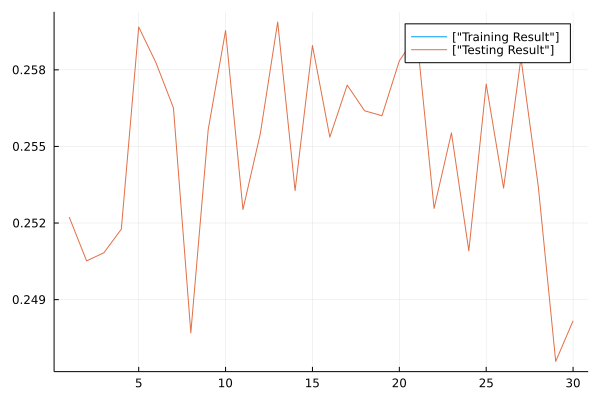

In [18]:
Plots.plot(train_acc_list,label=["Training Result"])
Plots.plot!(test,label=["Testing Result"])

In [19]:
"""
    In order to compute for confusion matrix
"""
#TT
TT = sum(vec(chromosomes[1](para_test_std) .> 0.5) .== 1)
#TF
TF = sum(vec(chromosomes[1](para_test_std) .> 0.5) .== 0)
#FT
FT = sum(vec(chromosomes[1](para_test_std) .< 0.5) .== 1)
#FF
FF = sum(vec(chromosomes[1](para_test_std) .< 0.5) .== 0)
println("confusion matrix:")
println("True True Result: $TT,  True False Result: $TF")
println("False False Result: $FF,   False True Result: FT")

confusion matrix:
True True Result: 218,  True False Result: 366
False False Result: 218,   False True Result: FT
